In [5]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import scipy.linalg
from sklearn.decomposition import PCA
import os
from matplotlib.colors import ListedColormap, Normalize
from scipy.interpolate import griddata
from scipy.interpolate import interp2d
from scipy.interpolate import Rbf
from scipy.interpolate import griddata, Rbf, UnivariateSpline
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap

from scipy.interpolate import RectBivariateSpline
from matplotlib import colors

#plt.style.use('./stylesheet.mplstyle')

In [45]:
# PCA as normal

In [46]:
filenames=os.listdir('pca_data')

In [47]:

mvals, uvals, orbs = [], [], []

for filename in filenames:
    if 'orb0' in filename:
        orb1_filename = filename.replace('orb0', 'orb1')

        m, u = map(float, (filename.split('_m')[1].split('_')[0], [segment[1:] for segment in filename.split('_') if segment.startswith('U')][0]))

        mvals.append(m)
        uvals.append(u)

        orb0_data = np.loadtxt(f'pca_data/{filename}')
        orb1_data = np.loadtxt(f'pca_data/{orb1_filename}')

        orbitals = np.concatenate((orb1_data[:, 1], orb0_data[:, 1]))
        #orbitals = orb1_data[:,1]-orb0_data[:,1]
        orbs.append(orbitals)

uvals=np.array(uvals)
mvals=np.array(mvals)


In [48]:
orbs = np.array(orbs)
pca = PCA(n_components=1)
principal_components = pca.fit_transform(orbs)
eigenvalues = pca.explained_variance_

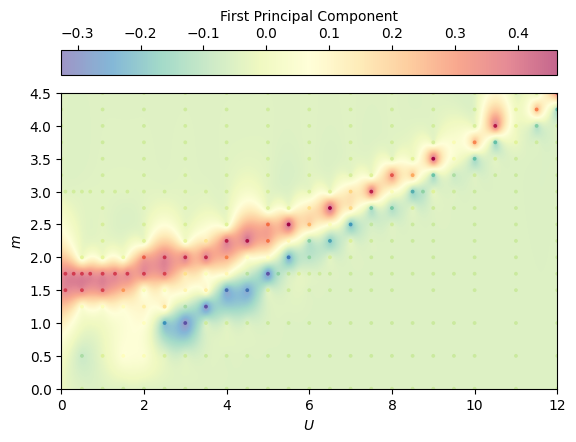

In [49]:
uvals = np.array(uvals)
mvals = np.array(mvals)


# Set the number of points for interpolation
num_points = 1000  

# Create a grid for interpolation 
u_grid, m_grid = np.meshgrid(np.linspace(min(uvals), max(uvals), num_points),
                             np.linspace(min(mvals), max(mvals), num_points))

rbf = Rbf(uvals, mvals, principal_components[:, 0], function='linear')
interp_vals = rbf(u_grid, m_grid)


normalized_values = (principal_components[:, 0] - (-0.2)) / (0.4 - (-0.2))

plt.imshow(interp_vals, extent=(min(uvals), max(uvals), min(mvals), max(mvals)),
           origin='lower', cmap='Spectral_r', aspect='auto', alpha=0.6)
plt.colorbar(label="First Principal Component",location='top')
plt.xlabel(r'$U$')
plt.scatter(uvals, mvals, c=normalized_values, cmap='Spectral_r', marker='o', s=3, alpha=1)
plt.ylabel(r'$m$')

#plt.savefig('PCAphasediagramBHZ.svg')
#plt.savefig('PCAphasediagramBHZ.pdf')
plt.show()


In [50]:
# Lets make some arbitrary classes, based on the PCA, to test the classifier.

In [51]:
encoded = principal_components[:, 0]

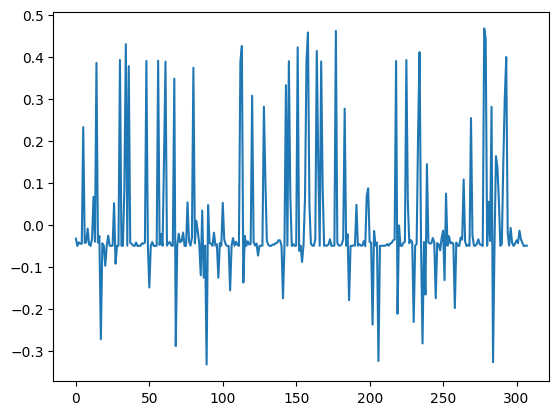

In [52]:
plt.plot(encoded)

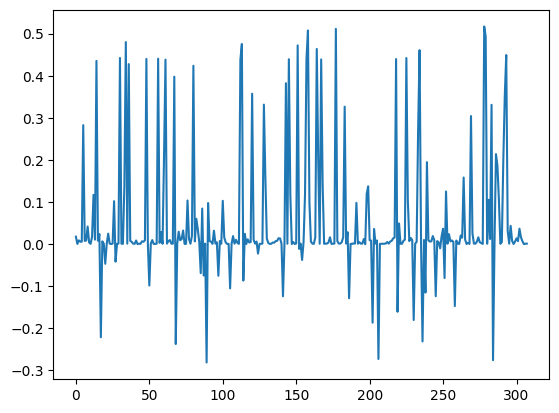

In [53]:
plt.plot(encoded+0.05)

In [54]:
encoded_normalized = encoded + 0.05 
great_pt1 = encoded_normalized > .12
less_pt1 = encoded_normalized < -0.01
near_zero = (great_pt1 + less_pt1) == 0

In [55]:
encoded_normalized[less_pt1] = 2
encoded_normalized[near_zero] = 0
encoded_normalized[great_pt1] = 3

In [56]:
is_upper = (mvals > uvals*4.5/12) * near_zero

In [57]:
encoded_normalized[is_upper] = 1

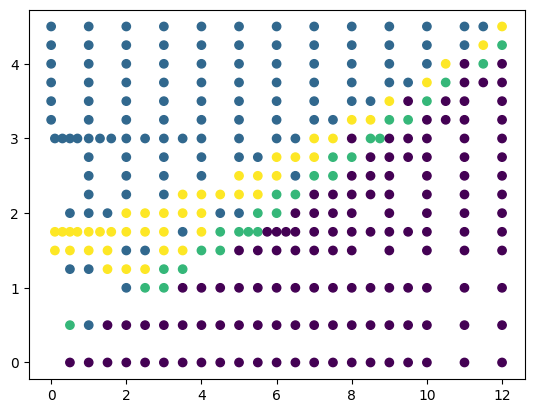

In [58]:
plt.scatter(uvals,mvals, c = encoded_normalized)

In [59]:
# Here we make the support vector classifiers

In [60]:
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier 

In [61]:
from sklearn import svm

In [62]:
new_mu = np.stack((uvals,mvals)).T # u, m

In [63]:
new_mu

array([[ 7.  ,  3.25],
       [ 8.5 ,  2.25],
       [ 0.3 ,  3.  ],
       [ 5.  ,  4.25],
       [ 7.  ,  4.5 ],
       [ 8.5 ,  3.25],
       [ 7.  ,  4.  ],
       [ 4.  ,  3.5 ],
       [11.  ,  4.25],
       [ 7.5 ,  2.25],
       [12.  ,  3.25],
       [ 2.5 ,  0.5 ],
       [ 4.5 ,  2.  ],
       [ 8.  ,  3.75],
       [ 0.5 ,  1.5 ],
       [ 6.  ,  1.75],
       [ 3.  ,  2.5 ],
       [ 5.5 ,  2.  ],
       [ 3.  ,  3.75],
       [ 9.5 ,  1.  ],
       [ 3.  ,  1.25],
       [ 8.5 ,  1.  ],
       [ 5.  ,  2.75],
       [ 8.  ,  0.  ],
       [ 7.  ,  1.5 ],
       [ 4.  ,  0.  ],
       [ 8.  ,  3.  ],
       [ 0.5 ,  0.5 ],
       [ 8.  ,  1.  ],
       [10.  ,  3.  ],
       [ 0.1 ,  1.75],
       [11.  ,  1.5 ],
       [ 9.5 ,  1.75],
       [ 4.  ,  1.75],
       [10.5 ,  4.  ],
       [ 5.  ,  0.  ],
       [ 2.5 ,  1.75],
       [ 8.  ,  2.5 ],
       [ 4.  ,  4.25],
       [11.  ,  1.  ],
       [10.  ,  2.  ],
       [ 2.  ,  3.25],
       [ 4.  ,  0.5 ],
       [ 9.

(0.0, 4.5)

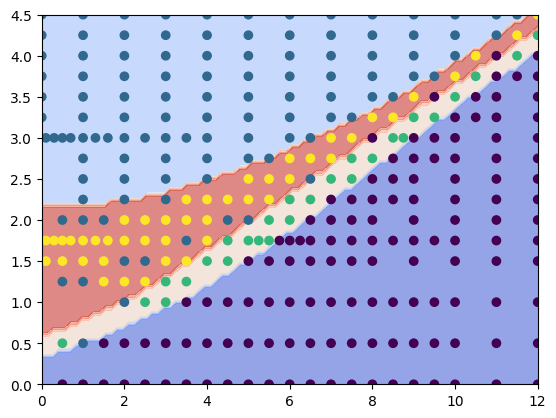

In [64]:
# making the RBF SVC

xy_list = new_mu
classes_list = encoded_normalized


C = 3000
gamma = .014

rbf_scv = svm.SVC(kernel="rbf", gamma=gamma, C=C, class_weight = 'balanced')
rbf_scv.fit(xy_list,classes_list)
disp = DecisionBoundaryDisplay.from_estimator(
        rbf_scv,
        xy_list,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.6
    )

# Here we also plot the points and their class
plt.scatter(uvals,mvals, c = encoded_normalized)
plt.xlim(0, 12)
plt.ylim(0, 4.5)

In [65]:
# make a grid to test how we can predict the class
num_points = 100
u_grid, m_grid = np.meshgrid(np.linspace(min(uvals), max(uvals), num_points),
                             np.linspace(min(mvals), max(mvals), num_points))
new_mu_grid = np.stack((u_grid.flatten(),m_grid.flatten())).T # u, m

In [66]:
predicted_encoded = rbf_scv.predict(new_mu_grid)

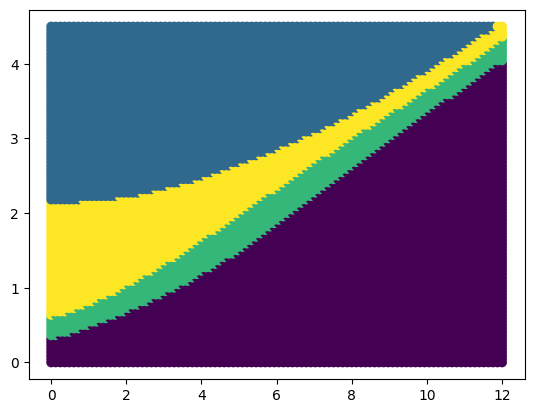

In [67]:
plt.scatter(u_grid.flatten(), m_grid.flatten(), c = predicted_encoded)

In [68]:
# Linear SVC

(0.0, 4.5)

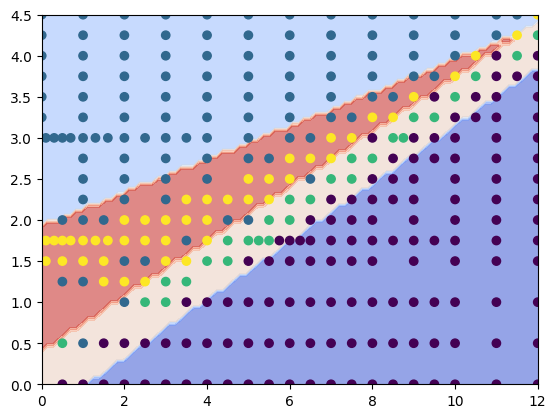

In [69]:
xy_list = new_mu
classes_list = encoded_normalized


C = .5

lin_svc = svm.SVC(kernel="linear", C=C, class_weight = 'balanced')
lin_svc.fit(new_mu,encoded_normalized)
disp = DecisionBoundaryDisplay.from_estimator(
        lin_svc,
        xy_list,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.6
    )


# Here we also plot the points and their class
plt.scatter(uvals,mvals, c = encoded_normalized)
plt.xlim(0, 12)
plt.ylim(0, 4.5)

In [70]:
x_grid = np.linspace(0, 12)

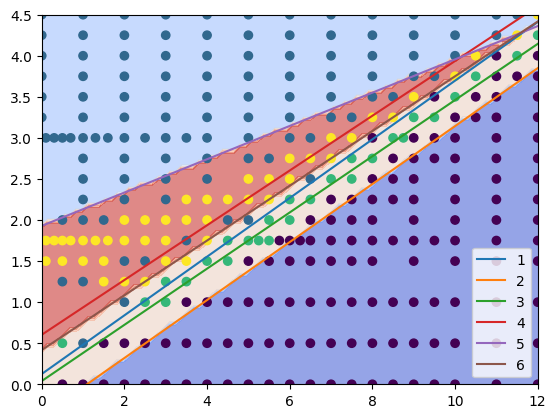

In [71]:
disp = DecisionBoundaryDisplay.from_estimator(
        lin_svc,
        xy_list,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.6
    )


label = 0 # this is just for the labels in the legend

for (coef_0, coef_1),intercept in zip(clf.coef_, clf.intercept_):
    y = -(coef_0 / coef_1) * x_grid - intercept/coef_1 # this is an equation in the form y = mx + b
    label = label + 1
    plt.plot(x_grid,y, label = label)
    
plt.xlim(0, 12)
plt.ylim(0, 4.5)
plt.scatter(uvals,mvals, c = encoded_normalized)
plt.legend()